In [1]:
import pandas as pd
import numpy as np
import datetime

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

pd.set_option('display.max_columns', None)
train = pd.read_csv('train.csv', parse_dates=['submitted_date'], date_parser=dateparse)

category_to_id = {cat: idx for idx, cat in enumerate(sorted(train['category'].unique()))}
train['id'] = train['category'].map(category_to_id)

train['year'] = train['submitted_date'].dt.isocalendar().year
train['week'] = train['submitted_date'].dt.isocalendar().week
min_year = train['year'].min()
train['week_id'] = (train['year'] - min_year) * 53 + train['week']

train = train.drop(columns=['category', 'year', 'week', 'submitted_date'])

tables_by_id = [group for _, group in train.groupby('id')]
for i, table in enumerate(tables_by_id):
    week_counts = table['week_id'].value_counts()
    full_weeks = week_counts[week_counts == 7].index
    tables_by_id[i] = table[table['week_id'].isin(full_weeks)].reset_index(drop=True)


C:\Users\Tora\AppData\Local\Temp\ipykernel_55780\673788907.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  train = pd.read_csv('train.csv', parse_dates=['submitted_date'], date_parser=dateparse)


In [2]:
final_train = pd.DataFrame(columns=train.columns)

for i, table in enumerate(tables_by_id):
    table_grouped = table.groupby('week_id', as_index=False)['num_papers'].sum()
    table_grouped['id'] = i
    final_train = pd.concat([final_train, table_grouped], ignore_index=True)

final_train

C:\Users\Tora\AppData\Local\Temp\ipykernel_55780\1603237161.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_train = pd.concat([final_train, table_grouped], ignore_index=True)


,num_papers,id,week_id
0,145,0,54
1,160,0,55
2,130,0,56
3,130,0,57
4,179,0,58
...,...,...,...
176079,42,139,1380
176080,34,139,1381
176081,32,139,1382
176082,53,139,1383


In [3]:
final_train['year'] = (final_train['week_id'] - 1) // 53 + min_year
final_train['week'] = (final_train['week_id'] - 1) % 53 + 1
final_train['week_start'] = pd.to_datetime(final_train['year'].astype(str) + '-W' + final_train['week'].astype(str) + '-1', format='%G-W%V-%u')

final_train['week_start'] = pd.to_datetime(final_train['week_start'], errors='coerce')

final_train = final_train.drop(columns=['week_id'])
cols = ['week_start', 'id', 'num_papers']
final_train = final_train[cols]

final_train

,week_start,id,num_papers
0,2000-01-03,0,145
1,2000-01-10,0,160
2,2000-01-17,0,130
3,2000-01-24,0,130
4,2000-01-31,0,179
...,...,...,...
176079,2025-01-06,139,42
176080,2025-01-13,139,34
176081,2025-01-20,139,32
176082,2025-01-27,139,53


In [4]:
final_train

,week_start,id,num_papers
0,2000-01-03,0,145
1,2000-01-10,0,160
2,2000-01-17,0,130
3,2000-01-24,0,130
4,2000-01-31,0,179
...,...,...,...
176079,2025-01-06,139,42
176080,2025-01-13,139,34
176081,2025-01-20,139,32
176082,2025-01-27,139,53


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from ncps.torch import LTC

class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len):
        xs, ys = [], []
        for i in range(len(series) - seq_len):
            xs.append(series[i : i + seq_len])
            ys.append(series[i + seq_len])
        self.X = torch.tensor(xs, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(ys, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LTCPredictor(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCPredictor, self).__init__()
        self.rnn = LTC(input_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_out = rnn_out[:, -1, :]  # Take the output at the last time step
        output = self.fc(last_out)
        return output
    
df = final_train
series = (
    df
    .sort_values('week_start')['num_papers']
    .values
)

seq_len = 4
dataset = TimeSeriesDataset(series, seq_len)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = LTCPredictor(2, 16, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    for Xb, yb in loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch}/{epochs}  Loss: {running_loss / len(loader):.4f}")

# 5. Forecast next 4 weeks
model.eval()
window = torch.tensor(series[-seq_len:], dtype=torch.float32) \
               .unsqueeze(0).unsqueeze(-1)
forecast = []
with torch.no_grad():
    for _ in range(8):
        out = model(window)
        pred = out.flatten().item()
        forecast.append(pred)
        window = torch.cat([window[:, 1:, :], out.unsqueeze(-1)], dim=1)

print("Next 8 weeks forecast:", forecast)

c:\Users\Tora\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (4) must match the size of tensor b (16) at non-singleton dimension 1

In [6]:
test = pd.read_csv('test.csv', date_parser=dateparse)

test

/tmp/ipykernel_13292/3465931760.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test = pd.read_csv('test.csv', date_parser=dateparse)


,category,week_id,week_start,week_end,num_papers
0,astro-ph,1,2025-02-10,2025-02-16,0
1,astro-ph,2,2025-02-17,2025-02-23,0
2,astro-ph,3,2025-02-24,2025-03-02,0
3,astro-ph,4,2025-03-03,2025-03-09,0
4,astro-ph,5,2025-03-10,2025-03-16,0
...,...,...,...,...,...
1115,stat.TH - Statistics Theory,4,2025-03-03,2025-03-09,0
1116,stat.TH - Statistics Theory,5,2025-03-10,2025-03-16,0
1117,stat.TH - Statistics Theory,6,2025-03-17,2025-03-23,0
1118,stat.TH - Statistics Theory,7,2025-03-24,2025-03-30,0


In [7]:
test['id'] = test['category'].map(category_to_id)

test = test[['id', 'week_start', 'num_papers']]
test = pd.concat([final_train])

test

,week_start,id,num_papers
0,2000-01-03,0,145.0
1,2000-01-10,0,160.0
2,2000-01-17,0,130.0
3,2000-01-24,0,130.0
4,2000-01-31,0,179.0
...,...,...,...
176079,2025-01-06,139,42.0
176080,2025-01-13,139,34.0
176081,2025-01-20,139,32.0
176082,2025-01-27,139,53.0


In [8]:
test['id'] = test['id'].astype(str)
test['num_papers'] = test['num_papers'].astype(float)

test_data = TimeSeriesDataFrame(
    final_train,
    id_column="id",
    timestamp_column="week_start")

test_data

num_papers
item_id timestamp             
0       2000-01-03       145.0
        2000-01-10       160.0
        2000-01-17       130.0
        2000-01-24       130.0
        2000-01-31       179.0
...                        ...
139     2025-01-06        42.0
        2025-01-13        34.0
        2025-01-20        32.0
        2025-01-27        53.0
        2025-02-03        58.0

[176084 rows x 1 columns]

In [9]:
predictions = predictor.predict(test_data)

predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
0       2025-02-10  336.444736  263.943071  290.203648  307.974036   
        2025-02-17  338.681238  246.533576  278.148811  302.288879   
        2025-02-24  346.857069  243.699512  277.298030  304.611905   
        2025-03-03  348.750481  227.020550  271.701461  302.355805   
        2025-03-10  350.859389  220.247029  263.534533  296.569881   
...                        ...         ...         ...         ...   
139     2025-03-03   37.190979   17.527812   24.619195   29.410820   
        2025-03-10   38.340891   16.481148   24.109575   29.688519   
        2025-03-17   37.052999   14.316245   22.892018   28.295516   
        2025-03-24   36.584072   12.086026   20.744783   26.668438   
        2025-03-31   34.317763    9.227410   17.401942   24.047393   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
0       2025-02-10  322.273373  336.444736  350.427849  366.555221   
        2025-02-17  321.449501  338.681238  356.021577  376.059535   
        2025-02-24  324.927800  346.857069  366.624450  389.871923   
        2025-03-03  326.648807  348.750481  371.757489  397.043781   
        2025-03-10  323.763826  350.859389  375.825599  401.375722   
...                        ...         ...         ...         ...   
139     2025-03-03   33.408246   37.190979   41.309030   45.644453   
        2025-03-10   33.852616   38.340891   42.219117   46.785681   
        2025-03-17   32.637464   37.052999   41.799305   46.590941   
        2025-03-24   32.196108   36.584072   41.118074   46.191194   
        2025-03-31   29.499854   34.317763   39.401892   44.887140   

                           0.8         0.9  
item_id timestamp                           
0       2025-02-10  383.702475  409.541232  
        2025-02-17  398.455497  430.380757  
        2025-02-24  417.528820  455.038183  
        2025-03-03  428.079264  467.158732  
        2025-03-10  436.066836  478.068401  
...                        ...         ...  
139     2025-03-03   51.599645   58.482714  
        2025-03-10   52.018807   59.599626  
        2025-03-17   52.928149   60.950381  
        2025-03-24   52.516820   60.601011  
        2025-03-31   51.537669   59.880865  

[1120 rows x 10 columns]

In [10]:
answer = predictions['mean']

answer

item_id  timestamp 
0        2025-02-10    336.444736
         2025-02-17    338.681238
         2025-02-24    346.857069
         2025-03-03    348.750481
         2025-03-10    350.859389
                          ...    
139      2025-03-03     37.190979
         2025-03-10     38.340891
         2025-03-17     37.052999
         2025-03-24     36.584072
         2025-03-31     34.317763
Name: mean, Length: 1120, dtype: float64

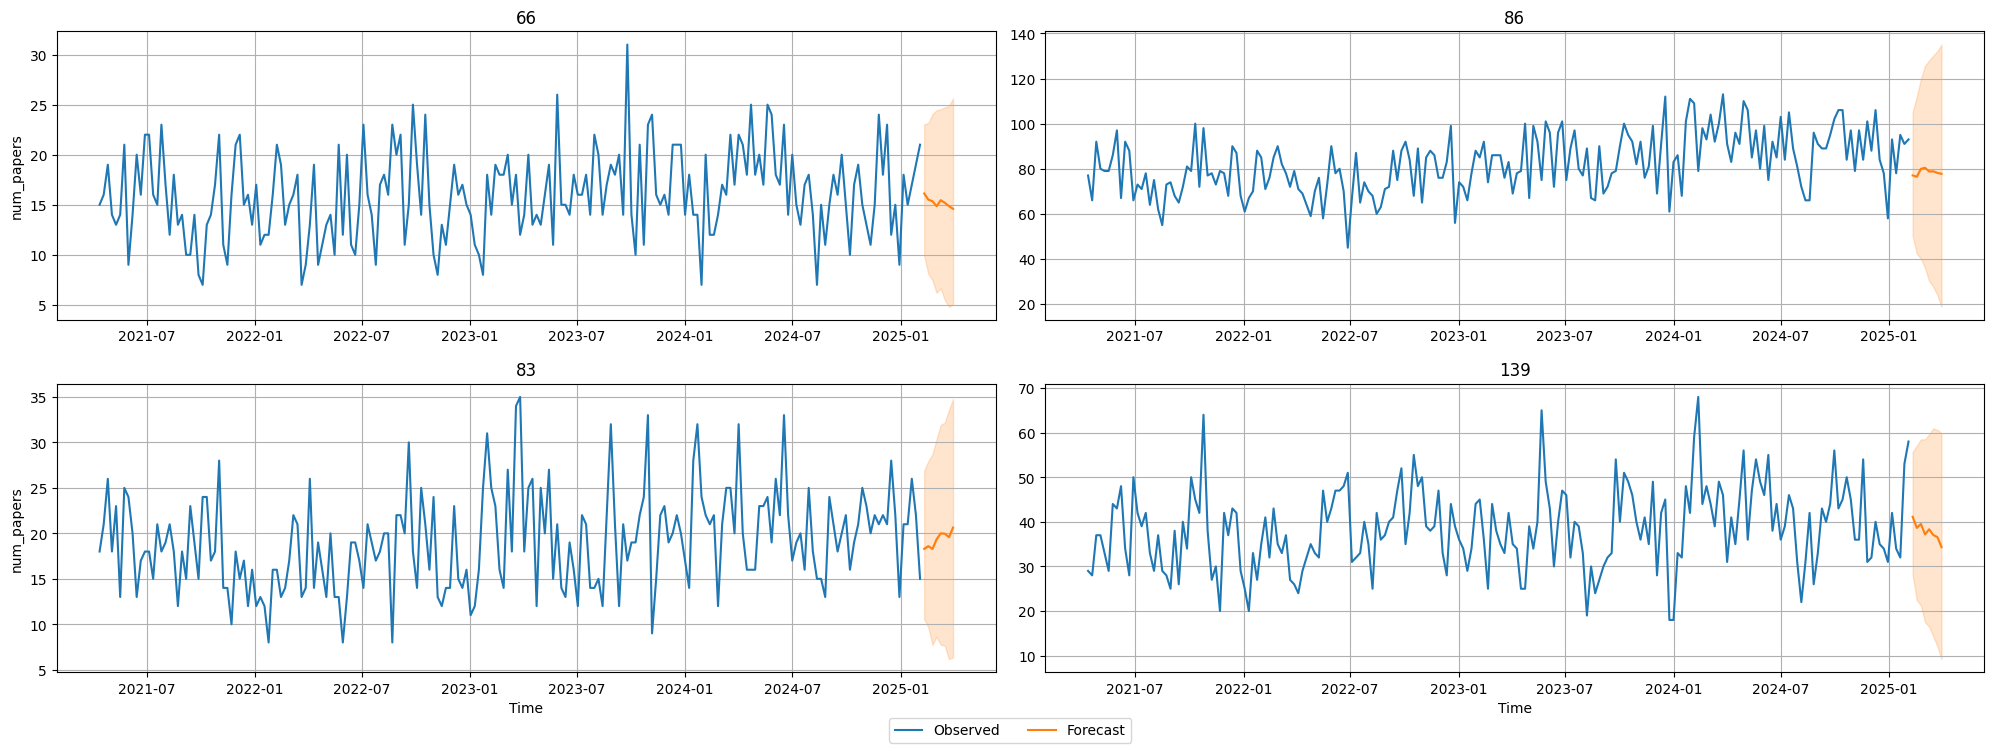

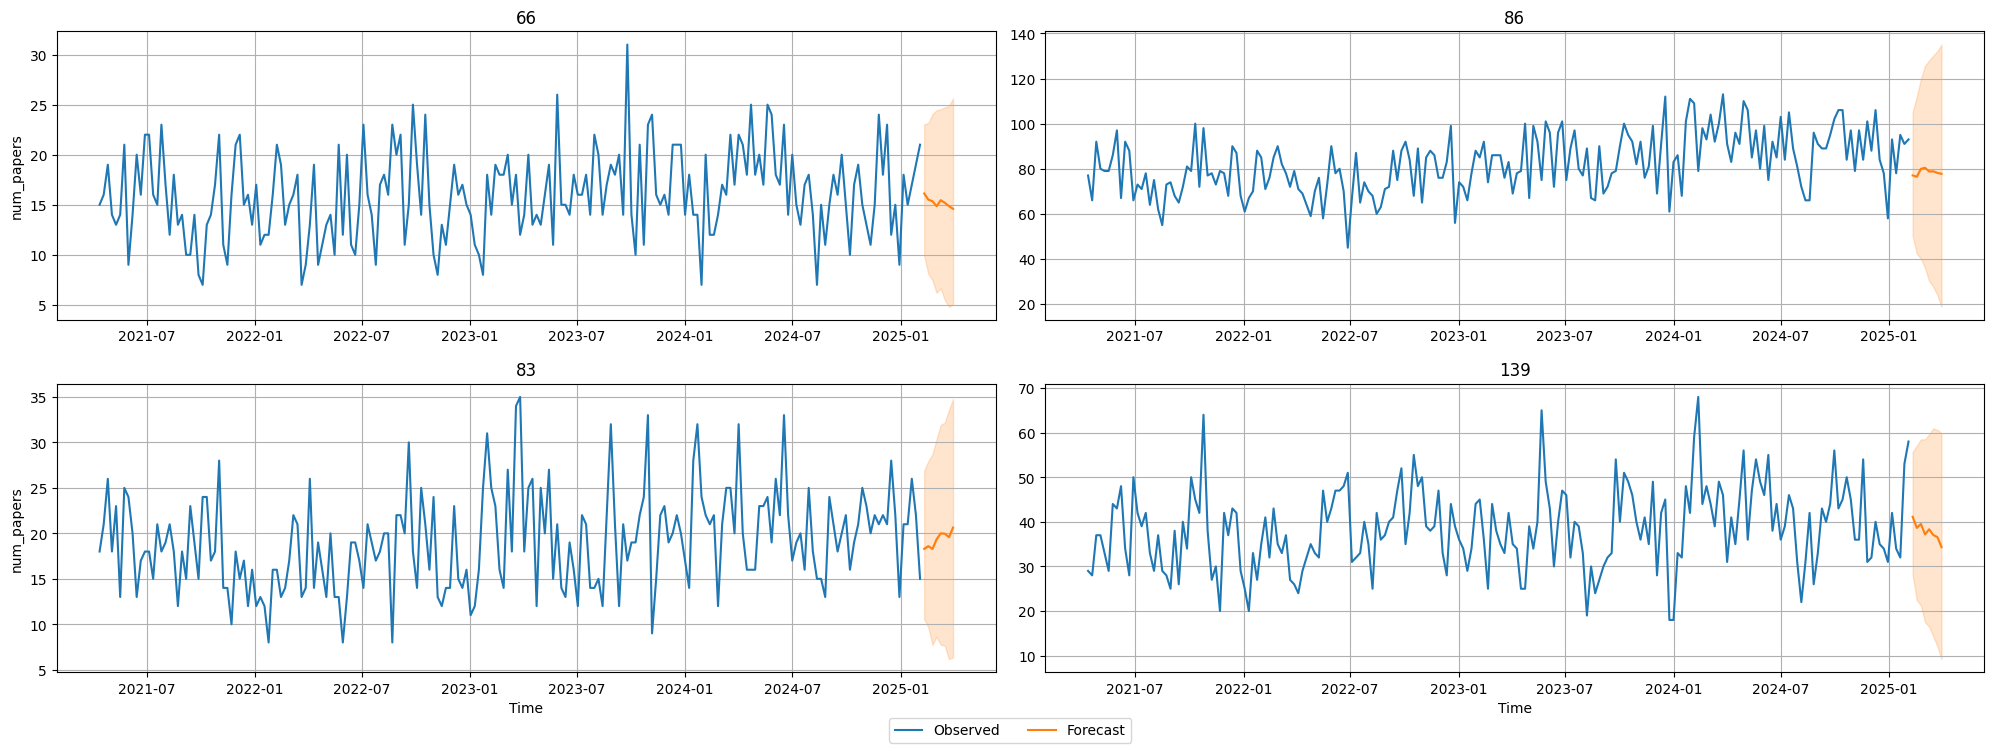

In [11]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [12]:
answer = answer.reset_index() 
answer

,item_id,timestamp,mean
0,0,2025-02-10,336.444736
1,0,2025-02-17,338.681238
2,0,2025-02-24,346.857069
3,0,2025-03-03,348.750481
4,0,2025-03-10,350.859389
...,...,...,...
1115,139,2025-03-03,37.190979
1116,139,2025-03-10,38.340891
1117,139,2025-03-17,37.052999
1118,139,2025-03-24,36.584072


In [13]:
id_to_category = {idx: cat for cat, idx in category_to_id.items()}
answer['item_id'] = answer['item_id'].astype(int)
answer['id'] = answer['item_id'].map(id_to_category)

answer

,item_id,timestamp,mean,id
0,0,2025-02-10,336.444736,astro-ph
1,0,2025-02-17,338.681238,astro-ph
2,0,2025-02-24,346.857069,astro-ph
3,0,2025-03-03,348.750481,astro-ph
4,0,2025-03-10,350.859389,astro-ph
...,...,...,...,...
1115,139,2025-03-03,37.190979,stat.TH - Statistics Theory
1116,139,2025-03-10,38.340891,stat.TH - Statistics Theory
1117,139,2025-03-17,37.052999,stat.TH - Statistics Theory
1118,139,2025-03-24,36.584072,stat.TH - Statistics Theory


In [14]:
counts = {}
def make_unique(name):
    cnt = counts.get(name, 0) + 1
    counts[name] = cnt
    return name if cnt == 0 else f"{name}__{cnt}"

answer['id'] = answer['id'].apply(make_unique)

answer

,item_id,timestamp,mean,id
0,0,2025-02-10,336.444736,astro-ph__1
1,0,2025-02-17,338.681238,astro-ph__2
2,0,2025-02-24,346.857069,astro-ph__3
3,0,2025-03-03,348.750481,astro-ph__4
4,0,2025-03-10,350.859389,astro-ph__5
...,...,...,...,...
1115,139,2025-03-03,37.190979,stat.TH - Statistics Theory__4
1116,139,2025-03-10,38.340891,stat.TH - Statistics Theory__5
1117,139,2025-03-17,37.052999,stat.TH - Statistics Theory__6
1118,139,2025-03-24,36.584072,stat.TH - Statistics Theory__7


In [15]:
final_answer = pd.DataFrame()

In [16]:
final_answer[['id', 'num_papers']] = answer[['id', 'mean']]

final_answer

,id,num_papers
0,astro-ph__1,336.444736
1,astro-ph__2,338.681238
2,astro-ph__3,346.857069
3,astro-ph__4,348.750481
4,astro-ph__5,350.859389
...,...,...
1115,stat.TH - Statistics Theory__4,37.190979
1116,stat.TH - Statistics Theory__5,38.340891
1117,stat.TH - Statistics Theory__6,37.052999
1118,stat.TH - Statistics Theory__7,36.584072


In [17]:
final_answer.to_csv('submission.csv', index=False)